In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

dataset_name = "tawsifurrahman/covid19-radiography-database"
zip_file_name = "covid19-radiography-database.zip"

!kaggle datasets download -d {dataset_name}

!mkdir datasets
!unzip {zip_file_name} -d datasets > /dev/null

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 778M/778M [00:28<00:00, 28.3MB/s]
100% 778M/778M [00:28<00:00, 28.2MB/s]


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_name = 'FILE NAME'
label_column = 'LABEL'

covid_meta_data = pd.read_excel('/content/datasets/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
normal_meta_data = pd.read_excel('/content/datasets/COVID-19_Radiography_Dataset/Normal.metadata.xlsx')

normal_meta_data = normal_meta_data.sample(n=3616)
normal_meta_data[file_name] = normal_meta_data[file_name].str.capitalize()

meta_data = pd.concat([covid_meta_data, normal_meta_data], axis=0, ignore_index=True)
meta_data[label_column] = meta_data[file_name].apply(lambda x: 1 if x.startswith('COVID') else 0)
meta_data = meta_data[[file_name, label_column]]
print(meta_data.shape)
meta_data.head()

(7232, 2)


,FILE NAME,LABEL
0,COVID-1,1
1,COVID-2,1
2,COVID-3,1
3,COVID-4,1
4,COVID-5,1


In [4]:
meta_data.tail()

,FILE NAME,LABEL
7227,Normal-7929,0
7228,Normal-320,0
7229,Normal-6096,0
7230,Normal-3693,0
7231,Normal-5984,0


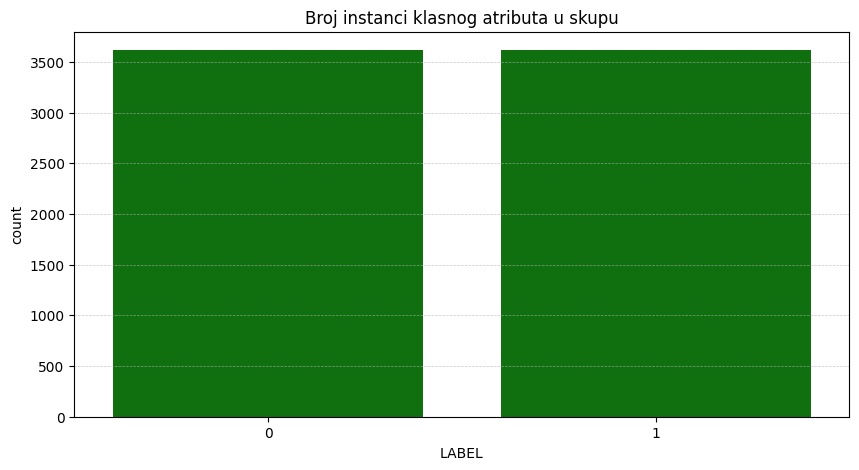

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

meta_data_label_counts = meta_data[label_column].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(data=meta_data_label_counts, color="green")
plt.title('Broj instanci klasnog atributa u skupu')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(meta_data, test_size=0.4,
                                     stratify=meta_data[label_column], random_state=42)

valid_df, test_df = train_test_split(temp_df, test_size=0.5,
                                     stratify=temp_df[label_column], random_state=42)

print("Training set:\n", train_df.shape)
print("\nValidation set:\n", valid_df.shape)
print("\nTest set:\n", test_df.shape)

Training set:
 (4339, 2)

Validation set:
 (1446, 2)

Test set:
 (1447, 2)


In [7]:
train_df[label_column].value_counts()

,count
LABEL,
1,2170
0,2169


In [8]:
test_df[label_column].value_counts()

,count
LABEL,
0,724
1,723


In [9]:
import os, cv2

IMG_SIZE = (256, 256)
dataset_dir = "/content/datasets/COVID-19_Radiography_Dataset"
x_train, x_valid, x_test, y_train, y_valid, y_test = [], [], [], [], [], []

def load_and_resize_img(path):
    img = cv2.imread(path)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype('float32') / 255.0
    return img

def get_subdir(label):
    if label == 0: return "/Normal"
    else: return "/COVID"

for index, row in train_df.iterrows():
  filename = row.get(file_name)
  label = row.get(label_column)
  subdir = get_subdir(label)
  filepath = os.path.join(dataset_dir + subdir, "images", filename + ".png")
  print(filepath)
  img = load_and_resize_img(filepath)
  x_train.append(img)
  y_train.append(label)

for index, row in valid_df.iterrows():
  filename = row.get(file_name)
  label = row.get(label_column)
  subdir = get_subdir(label)
  filepath = os.path.join(dataset_dir + subdir, "images", filename + ".png")
  img = load_and_resize_img(filepath)
  x_valid.append(img)
  y_valid.append(label)

for index, row in test_df.iterrows():
  filename = row.get(file_name)
  label = row.get(label_column)
  subdir = get_subdir(label)
  filepath = os.path.join(dataset_dir + subdir, "images", filename + ".png")
  img = load_and_resize_img(filepath)
  x_test.append(img)
  y_test.append(label)

/content/datasets/COVID-19_Radiography_Dataset/COVID/images/COVID-1791.png
/content/datasets/COVID-19_Radiography_Dataset/COVID/images/COVID-355.png
/content/datasets/COVID-19_Radiography_Dataset/COVID/images/COVID-2037.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-8816.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-3130.png
/content/datasets/COVID-19_Radiography_Dataset/COVID/images/COVID-550.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-9499.png
/content/datasets/COVID-19_Radiography_Dataset/COVID/images/COVID-1156.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-9136.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-972.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-6468.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-4871.png
/content/datasets/COVID-19_Radiography_Dataset/Normal/images/Normal-3540.png
/content/dat

In [10]:
import numpy as np

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)
y_test = label_encoder.fit_transform(y_test)

y_train = to_categorical(y_train, 2)
y_valid = to_categorical(y_valid, 2)
y_test = to_categorical(y_test, 2)

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K

K.clear_session()

In [ ]:
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    loss = y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin))
    return K.sum(loss, axis=-1)

In [ ]:
from tensorflow.keras import activations
from tensorflow.keras.layers import Layer

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_capsule_dim = input_shape[-1]
        self.kernel = self.add_weight(
                        name='capsule_kernel',
                        shape=(1, input_capsule_dim,
                                self.num_capsule * self.dim_capsule),
                        initializer='glorot_uniform',
                        trainable=True)

    def call(self, inputs):
        hat_inputs = K.conv1d(inputs, self.kernel)
        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:,:,:,0])
        for i in range(self.routings):
            c = K.softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, hat_inputs)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, hat_inputs)

        return squash(o)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import Reshape, Lambda, Dropout
from tensorflow.keras import Model, optimizers

def conv_block(input_layer):
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    return x

def primary_capsule_block(x):
    x = Reshape((-1, 128))(x)
    x = Capsule(32, 8, 3)(x)
    return x

def class_capsule_block(x):
    capsule = Capsule(2, 16, 3)(x)
    output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
    return output

input = Input(shape=(None, None, 3))
conv_output = conv_block(input)
primary_caps = primary_capsule_block(conv_output)
output = class_capsule_block(primary_caps)

model = Model(inputs=[input], outputs=[output])

adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss=margin_loss, optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, None, None, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, None, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, None, None, 32)      │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, None, None, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_2 (Capsule)                  │ (None, 32, 8)               │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_3 (Capsule)                  │ (None, 2, 16)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,720 (385.62 KB)

 Trainable params: 98,656 (385.38 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(4339, 256, 256, 3)
(4339, 2)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BATCH_SIZE = 8
EPOCHS = 50

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10,
                                                 min_lr=1e-7, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    [x_train], [y_train],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=[[x_valid], [y_valid]],
    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 124s 185ms/step - accuracy: 0.5377 - loss: 0.2339 - val_accuracy: 0.5000 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 2/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 72s 132ms/step - accuracy: 0.6329 - loss: 0.2011 - val_accuracy: 0.6231 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 3/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 134ms/step - accuracy: 0.6372 - loss: 0.1976 - val_accuracy: 0.5844 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 4/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - accuracy: 0.6743 - loss: 0.1855 - val_accuracy: 0.5256 - val_loss: 0.2569 - learning_rate: 0.0010
Epoch 5/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - accuracy: 0.6965 - loss: 0.1767 - val_accuracy: 0.5367 - val_loss: 0.2467 - learning_rate: 0.0010
Epoch 6/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - accuracy: 0.7165 - loss: 0.1645 - val_accuracy: 0.7808 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 7/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - accuracy: 0.

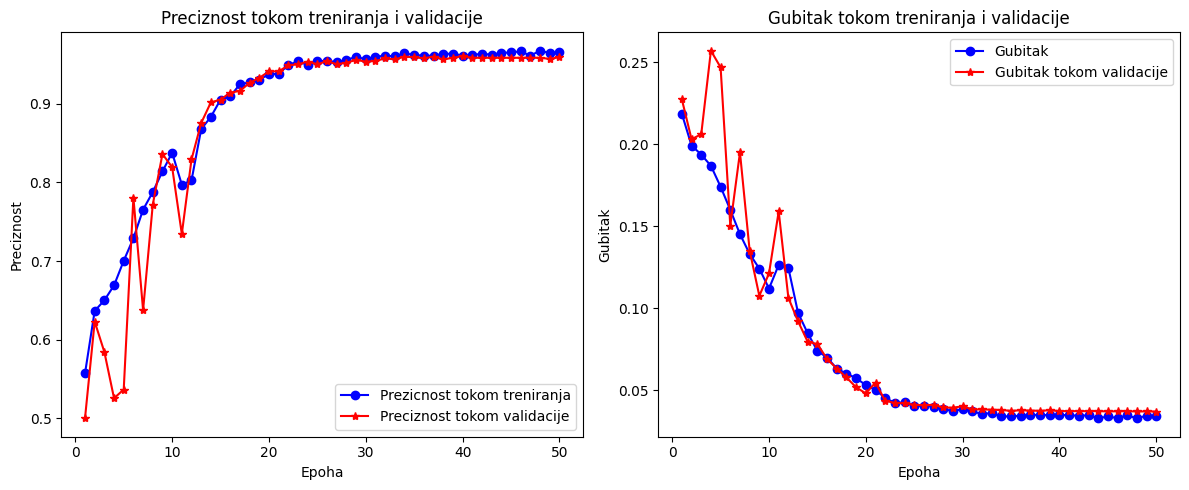

In [ ]:
history_df = history.history

acc = history_df['accuracy']
val_acc = history_df['val_accuracy']
loss = history_df['loss']
val_loss = history_df['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Prezicnost tokom treniranja')
plt.plot(epochs, val_acc, 'r*-', label='Preciznost tokom validacije')
plt.title('Preciznost tokom treniranja i validacije')
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Gubitak')
plt.plot(epochs, val_loss, 'r*-', label='Gubitak tokom validacije')
plt.title('Gubitak tokom treniranja i validacije')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate([x_test], [y_test], batch_size=BATCH_SIZE)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.9642 - loss: 0.0358
Test Loss: 0.036089781671762466
Test Accuracy: 0.9592260122299194


In [ ]:
y_pred= model.predict(x_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 266ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_new,y_pred))


              precision    recall  f1-score   support

           0       0.95      0.96      0.96       724
           1       0.96      0.95      0.96       723

    accuracy                           0.96      1447
   macro avg       0.96      0.96      0.96      1447
weighted avg       0.96      0.96      0.96      1447



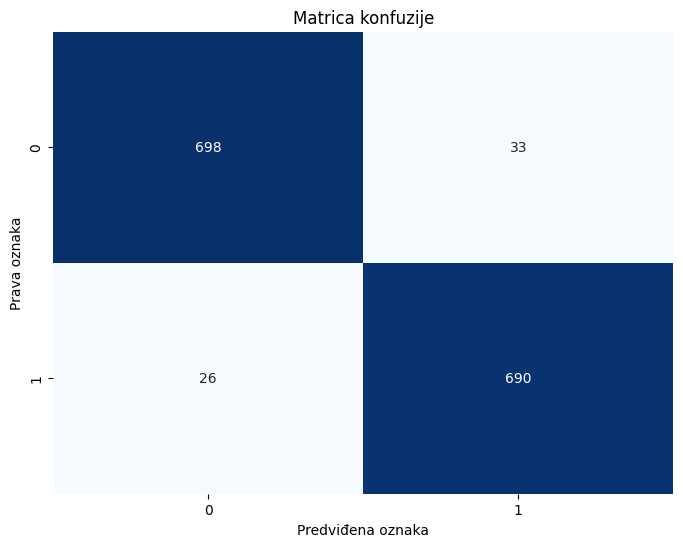

In [ ]:
cm = confusion_matrix(y_pred, y_test_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matrica konfuzije")
plt.xlabel("Predviđena oznaka")
plt.ylabel("Prava oznaka")

plt.show()

In [27]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model, optimizers

def conv_block(input_layer):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    return x

input = Input(shape=(256, 256, 3))
conv_output = conv_block(input)

x = Flatten()(conv_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=[input], outputs=[output])

adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │      67,109,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,208,226 (256.38 MB)

 Trainable params: 67,208,034 (256.38 MB)

 Non-trainable params: 192 (768.00 B)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BATCH_SIZE = 32
EPOCHS = 50

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10,
                                                 min_lr=1e-7, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    [x_train], [y_train],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=[[x_valid], [y_valid]],
    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 58s 291ms/step - accuracy: 0.5347 - loss: 25.9860 - val_accuracy: 0.5000 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.6173 - loss: 0.6602 - val_accuracy: 0.5007 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.6535 - loss: 0.6295 - val_accuracy: 0.7068 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.6527 - loss: 0.6020 - val_accuracy: 0.7033 - val_loss: 0.5625 - learning_rate: 0.0010
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.6171 - loss: 0.6395 - val_accuracy: 0.7545 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.6507 - loss: 0.5878 - val_accuracy: 0.7379 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.

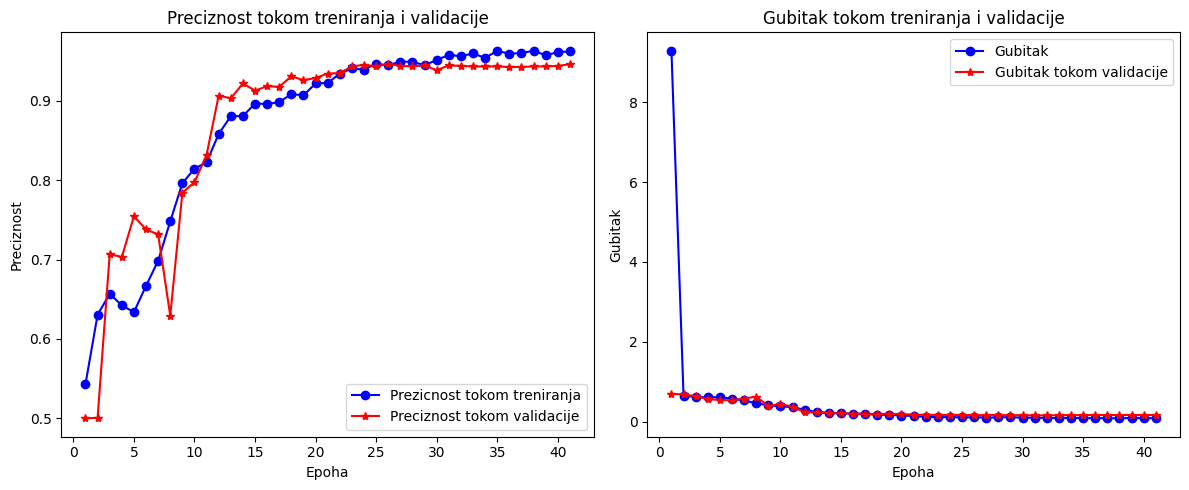

In [29]:
history_df = history.history

acc = history_df['accuracy']
val_acc = history_df['val_accuracy']
loss = history_df['loss']
val_loss = history_df['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Prezicnost tokom treniranja')
plt.plot(epochs, val_acc, 'r*-', label='Preciznost tokom validacije')
plt.title('Preciznost tokom treniranja i validacije')
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Gubitak')
plt.plot(epochs, val_loss, 'r*-', label='Gubitak tokom validacije')
plt.title('Gubitak tokom treniranja i validacije')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
test_loss, test_accuracy = model.evaluate([x_test], [y_test], batch_size=BATCH_SIZE)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9511 - loss: 0.1320
Test Loss: 0.14639179408550262
Test Accuracy: 0.94609534740448


In [31]:
y_pred= model.predict(x_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [32]:
y_pred = np.argmax(y_pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_new,y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       724
           1       0.95      0.94      0.95       723

    accuracy                           0.95      1447
   macro avg       0.95      0.95      0.95      1447
weighted avg       0.95      0.95      0.95      1447



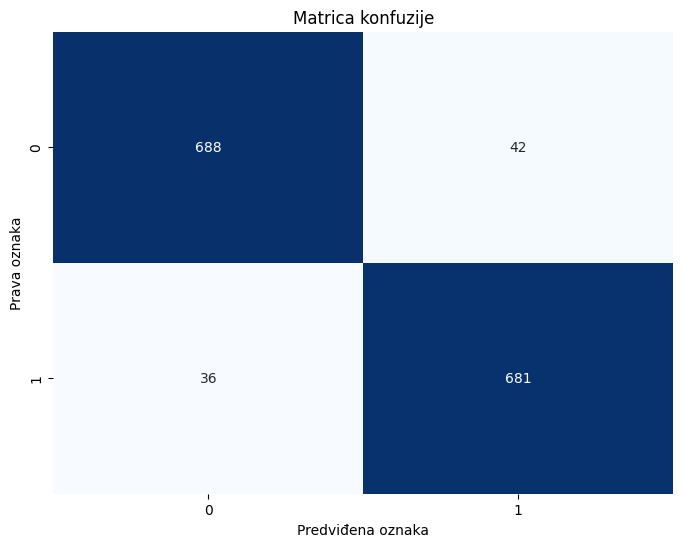

In [34]:
cm = confusion_matrix(y_pred, y_test_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matrica konfuzije")
plt.xlabel("Predviđena oznaka")
plt.ylabel("Prava oznaka")

plt.show()